In [32]:
import numpy as np 
import pandas as pd
import time
import random

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.style.use("seaborn-pastel")

%matplotlib inline


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import preprocessing

# Preprocessing

In [9]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
df = pd.DataFrame(wine.data.original)

#set seeds to get reproducible results
np.random.seed(3)
random.seed(3)
tf.random.set_seed(3)

df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


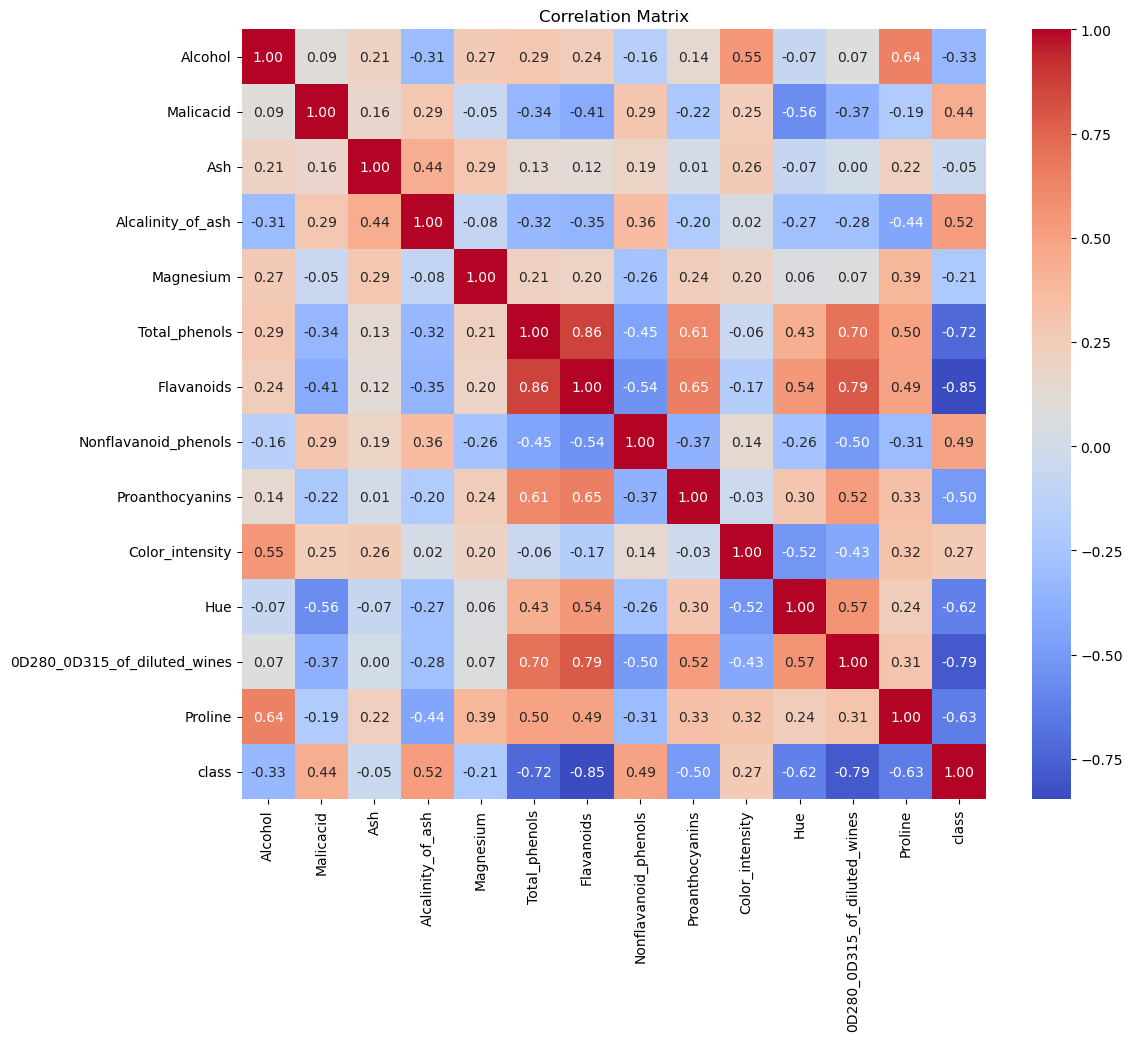

In [10]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [11]:
threshold = 0.7
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1.0)
correlated_variables = [pair for pair in highly_correlated if any(highly_correlated[pair])]
print(correlated_variables)

['Total_phenols', 'Flavanoids', '0D280_0D315_of_diluted_wines', 'class']


Correlated variables impact decision tree outputs. We will drop these features from the data.

In [12]:
#Dropping variables listed above that are correlated
df = df.drop(['Total_phenols', 'Flavanoids', '0D280_0D315_of_diluted_wines'], axis=1)
#check to verify
df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Proline,class
0,14.23,1.71,2.43,15.6,127,0.28,2.29,5.64,1.04,1065,1
1,13.20,1.78,2.14,11.2,100,0.26,1.28,4.38,1.05,1050,1
2,13.16,2.36,2.67,18.6,101,0.30,2.81,5.68,1.03,1185,1
3,14.37,1.95,2.50,16.8,113,0.24,2.18,7.80,0.86,1480,1
4,13.24,2.59,2.87,21.0,118,0.39,1.82,4.32,1.04,735,1
...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,0.52,1.06,7.70,0.64,740,3
174,13.40,3.91,2.48,23.0,102,0.43,1.41,7.30,0.70,750,3
175,13.27,4.28,2.26,20.0,120,0.43,1.35,10.20,0.59,835,3
176,13.17,2.59,2.37,20.0,120,0.53,1.46,9.30,0.60,840,3


In [15]:
def preprocessor(df):
    """
    Preprocesses the dataset by encoding categorical features using LabelEncoder

    Args:
        df (pandas.DataFrame): Input dataset

    Returns:
        pandas.DataFrame: Processed dataset with encoded categorical features
    """
    # make a copy of the original dataframe to avoid modifying the original data
    res_df = df.copy()
    
    # initialize LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # encode categorical features using LabelEncoder
    res_df['Alcohol'] = le.fit_transform(res_df['Alcohol'])
    res_df['Malicacid'] = le.fit_transform(res_df['Malicacid'])
    res_df['Ash'] = le.fit_transform(res_df['Ash'])
    res_df['Alcalinity_of_ash'] = le.fit_transform(res_df['Alcalinity_of_ash'])
    res_df['Magnesium'] = le.fit_transform(res_df['Magnesium'])
    res_df['Nonflavanoid_phenols'] = le.fit_transform(res_df['Nonflavanoid_phenols'])
    res_df['Proanthocyanins'] = le.fit_transform(res_df['Proanthocyanins'])
    res_df['Color_intensity'] = le.fit_transform(res_df['Color_intensity'])
    res_df['Hue'] = le.fit_transform(res_df['Hue'])
    res_df['Proline'] = le.fit_transform(res_df['Proline'])
    res_df['class'] = le.fit_transform(res_df['class'])
    
    # Return the processed dataframe
    return res_df

# Run the preprocessor function on the desired dataset
encoded_df = preprocessor(df)

In [16]:
#selecting features
X = encoded_df.drop(['class'],axis =1)
y = encoded_df['class']

In [17]:
#standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

In [18]:
#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 34)

# Model Implementation

Train Time (seconds) of Gini Decision Tree without PCA: 0.0028371810913085938
Accuracy of Gini Decision Tree without PCA: 0.9333333333333333
Train Time (seconds) of Entropy Decision Tree without PCA: 0.00136566162109375
Accuracy of Entropy Decision Tree without PCA: 0.9555555555555556


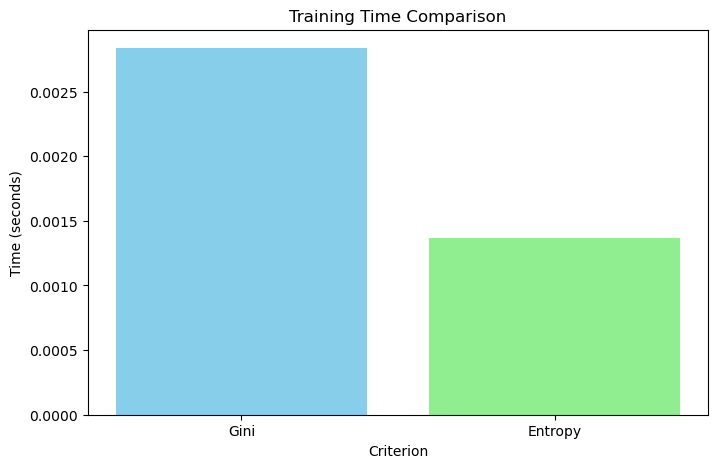

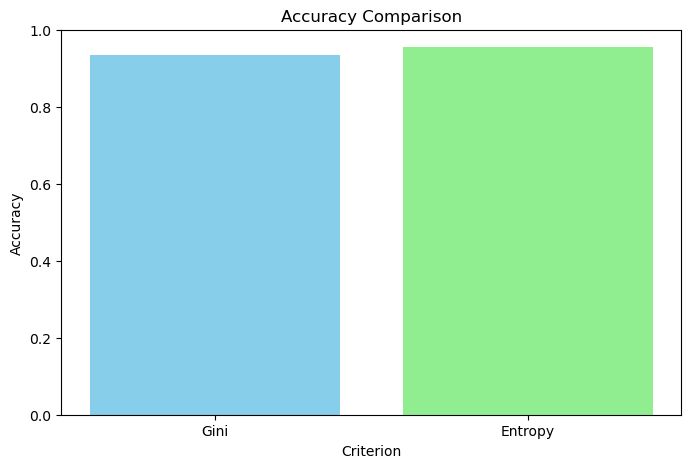

In [37]:
# Initialize lists to store training times and accuracies
train_times = []
accuracies_gini = []
accuracies_entropy = []

# Decision Tree with Gini impurity
start = time.time()

# Instantiate the model with Gini impurity
dt_gini = DecisionTreeClassifier(max_depth=4, random_state=1, criterion='gini')

# Fit the model with data
dt_gini.fit(X_train, y_train)

end = time.time()
dt_gini_time = end - start
train_times.append(dt_gini_time)
print('Train Time (seconds) of Gini Decision Tree without PCA:', dt_gini_time)

# Predict using the trained model
y_pred_gini = dt_gini.predict(X_test)

# Calculate accuracy
accuracy_gini = accuracy_score(y_test, y_pred_gini)
accuracies_gini.append(accuracy_gini)
print('Accuracy of Gini Decision Tree without PCA:', accuracy_gini)

# Decision Tree with Entropy
start = time.time()

# Instantiate the model with Entropy
dt_entropy = DecisionTreeClassifier(max_depth=4, random_state=1, criterion='entropy')

# Fit the model with data
dt_entropy.fit(X_train, y_train)

end = time.time()
dt_entropy_time = end - start
train_times.append(dt_entropy_time)
print('Train Time (seconds) of Entropy Decision Tree without PCA:', dt_entropy_time)

# Predict using the trained model
y_pred_entropy = dt_entropy.predict(X_test)

# Calculate accuracy
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
accuracies_entropy.append(accuracy_entropy)
print('Accuracy of Entropy Decision Tree without PCA:', accuracy_entropy)

# Plot training times
plt.figure(figsize=(8, 5))
plt.bar(['Gini', 'Entropy'], train_times, color=['skyblue', 'lightgreen'])
plt.title('Training Time Comparison')
plt.xlabel('Criterion')
plt.ylabel('Time (seconds)')
plt.show()

# Plot accuracies
plt.figure(figsize=(8, 5))
plt.bar(['Gini', 'Entropy'], [accuracy_gini, accuracy_entropy], color=['skyblue', 'lightgreen'])
plt.title('Accuracy Comparison')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

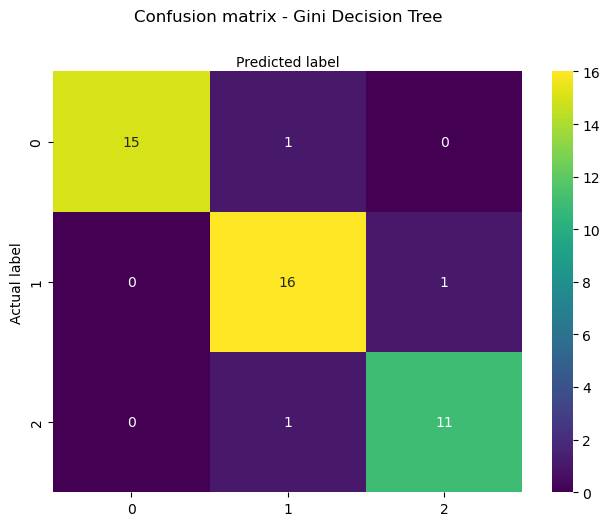

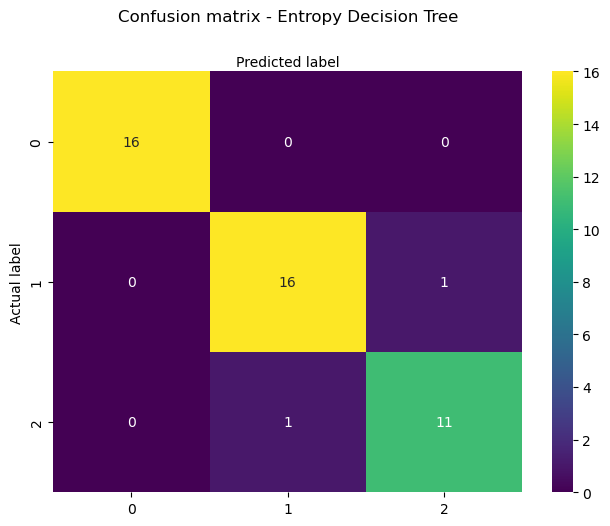

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        title (str): Title for the plot.
    """
    # Create confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    class_names = ['0', '1', '2']  # Name of classes

    # Create the figure
    fig, ax = plt.subplots()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Add the heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(title, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Plot confusion matrix for Gini Decision Tree
plot_confusion_matrix(y_test, y_pred_gini, 'Confusion matrix - Gini Decision Tree')

# Plot confusion matrix for Entropy Decision Tree
plot_confusion_matrix(y_test, y_pred_entropy, 'Confusion matrix - Entropy Decision Tree')

In [39]:
def print_classification_report(y_true, y_pred, title):
    """
    Print a formatted classification report.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        title (str): Title for the classification report.
    """
    classify_report = classification_report(y_true, y_pred)
    print(f"\nClassification Report - {title}")
    print(classify_report)

# Print classification report for Gini Decision Tree
print_classification_report(y_test, y_pred_gini, "Gini")

# Print classification report for Entropy Decision Tree
print_classification_report(y_test, y_pred_entropy, "Entropy")


Classification Report - Gini
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.89      0.94      0.91        17
           2       0.92      0.92      0.92        12

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


Classification Report - Entropy
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        17
           2       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



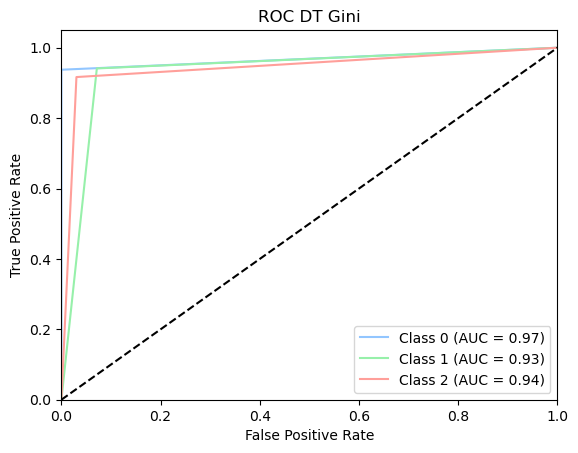

In [40]:
# Generate predictions
y_pred_prob = dt_gini.predict_proba(X_test)

# Binarize the labels using the OvR strategy
y_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(y_bin.shape[1]):  # Loop over each class
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set the limits for the x-axis and y-axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the label for the x-axis
plt.xlabel('False Positive Rate')

# Set the label for the y-axis
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('ROC DT Gini')

# Display the legend at the lower right corner
plt.legend(loc="lower right")

# Show the plot
plt.show()

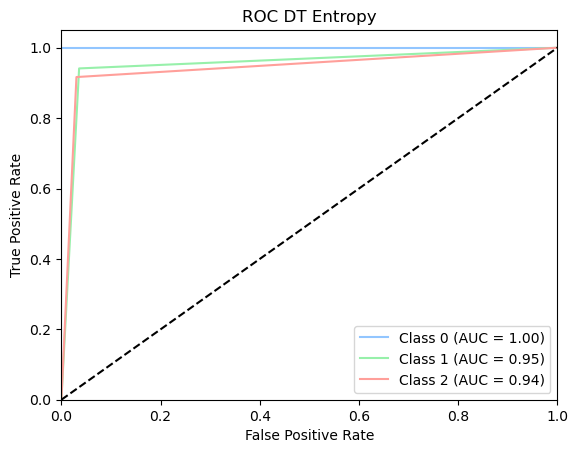

In [41]:
# Generate predictions
y_pred_prob = dt_entropy.predict_proba(X_test)

# Binarize the labels using the OvR strategy
y_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(y_bin.shape[1]):  # Loop over each class
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set the limits for the x-axis and y-axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the label for the x-axis
plt.xlabel('False Positive Rate')

# Set the label for the y-axis
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('ROC DT Entropy')

# Display the legend at the lower right corner
plt.legend(loc="lower right")

# Show the plot
plt.show()

Gini Decision Tree
Nodes: 17
Depth: 4


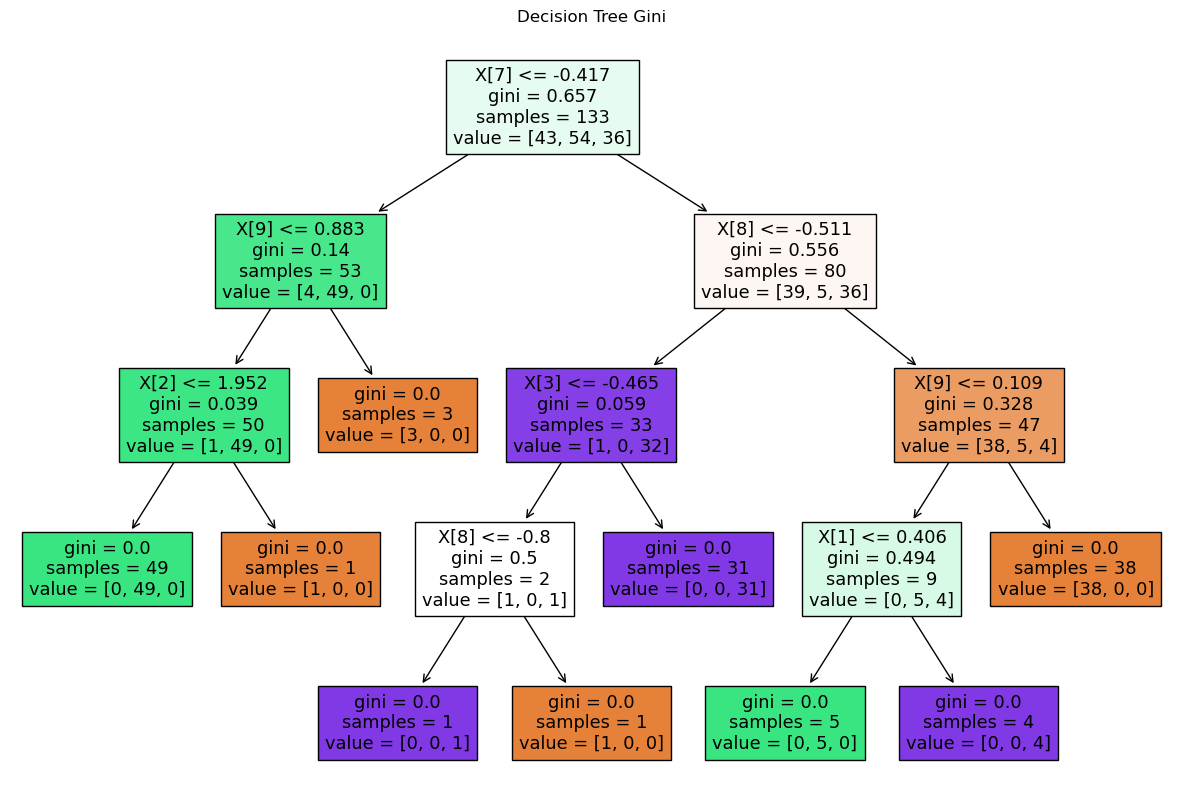

In [44]:
# Number of nodes and depth of decision tree w/ Gini
# Get the number of nodes in the decision tree
n_nodes = dt_gini.tree_.node_count

# Get the maximum depth of the decision tree
depth = dt_gini.tree_.max_depth

# Print information about the Gini Decision Tree without PCA
print('Gini Decision Tree')
print('Nodes:', n_nodes)
print('Depth:', depth)

# Plot the decision tree
plt.figure(figsize=(15, 10))  # Set the figure size
plot_tree(dt_gini, filled=True)  # Plot the decision tree with filled nodes and feature names
plt.title('Decision Tree Gini')  # Add a title to the plot
plt.show()  # Display the plot

Entropy Decision Tree
Nodes: 17
Depth: 4


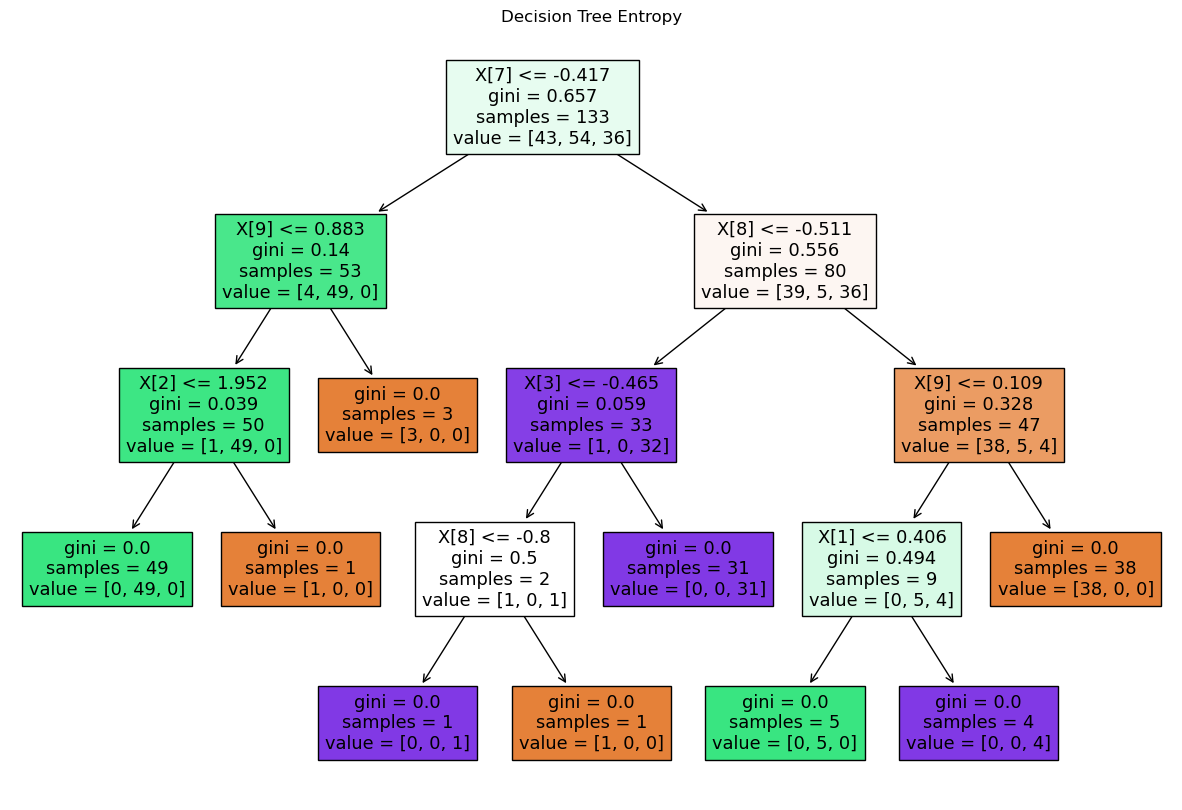

In [47]:
# Number of nodes and depth of decision tree w/ Gini
# Get the number of nodes in the decision tree
n_nodes = dt_entropy.tree_.node_count

# Get the maximum depth of the decision tree
depth = dt_entropy.tree_.max_depth

# Print information about the Entropy Decision Tree without PCA
print('Entropy Decision Tree')
print('Nodes:', n_nodes)
print('Depth:', depth)

# Plot the decision tree
plt.figure(figsize=(15, 10))  # Set the figure size
plot_tree(dt_gini, filled=True)  # Plot the decision tree with filled nodes and feature names
plt.title('Decision Tree Entropy')  # Add a title to the plot
plt.show()  # Display the plot